In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import ast
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture

In [18]:
expenditures_by_users= pd.read_csv('dataset2_expenditures_by_users.csv')

In [19]:
expenditures_by_users

,Account No,total_transactions,total_spent,median_transaction,mean_transaction,business_interactions,user_interactions,most_recent_transaction
0,101531259.0,110,17627.58,88.580,160.250727,"['LBG', 'Disney', 'Grand Union BJJ', 'Matalan'...",[],2023-12-05
1,104832000.0,150,25115.52,49.920,167.436800,"['LBG', 'Netflix', 'Grand Union BJJ', 'Blizzar...",[587923845.0],2023-12-03
2,105375973.0,146,10067.28,48.160,68.953973,"['PureGym', 'Netflix', 'Amazon', ""Blackwell's""...",[],2023-12-03
3,106601471.0,180,7760.01,19.965,43.111167,"['Mojang Studios', 'Netflix', 'The Crown', ""Bl...",[],2023-12-06
4,108481285.0,344,15062.28,21.510,43.785698,"['Disney', 'Amazon', 'PureGym', ""Blackwell's"",...",[913801979.0],2023-12-06
...,...,...,...,...,...,...,...,...
971,995615876.0,172,17598.80,52.920,102.318605,"['LBG', 'Blizzard', 'Mojang Studios', 'The Cro...",[],2023-12-05
972,996042490.0,243,35268.01,34.970,145.135844,"['Halifax', 'Netflix', 'PureGym', ""Blackwell's...",[792845450.0],2023-12-06
973,998390769.0,140,21323.35,69.990,152.309643,"['Halifax', 'Disney', 'Netflix', 'Mojang Studi...",[],2023-12-01
974,998405607.0,145,8816.16,35.070,60.801103,"['Xbox', 'Blizzard', 'Mojang Studios', 'Netfli...",[],2023-11-30


### Creating RFM dataframe

To calculate the recency value, I will calculate the days between the first date recorded (01/01/2023) and the user's most recent date of transaction. The Frequency value is from the 'total_transactions' column, and the Monetary value is from the 'total_spent' column.

In [24]:
expenditures_by_users['most_recent_transaction'] = pd.to_datetime(expenditures_by_users['most_recent_transaction'])

# Defining the start date
start_date = pd.to_datetime('2023-01-01')

# Calculating the difference in days
expenditures_by_users['recency_days'] = (expenditures_by_users['most_recent_transaction'] - start_date).dt.days

# Displaying the first few rows to verify the 'recency_days' column
expenditures_by_users.head()


,Account No,total_transactions,total_spent,median_transaction,mean_transaction,business_interactions,user_interactions,most_recent_transaction,recency_days
0,101531259.0,110,17627.58,88.580,160.250727,"['LBG', 'Disney', 'Grand Union BJJ', 'Matalan'...",[],2023-12-05,338
1,104832000.0,150,25115.52,49.920,167.436800,"['LBG', 'Netflix', 'Grand Union BJJ', 'Blizzar...",[587923845.0],2023-12-03,336
2,105375973.0,146,10067.28,48.160,68.953973,"['PureGym', 'Netflix', 'Amazon', ""Blackwell's""...",[],2023-12-03,336
3,106601471.0,180,7760.01,19.965,43.111167,"['Mojang Studios', 'Netflix', 'The Crown', ""Bl...",[],2023-12-06,339
4,108481285.0,344,15062.28,21.510,43.785698,"['Disney', 'Amazon', 'PureGym', ""Blackwell's"",...",[913801979.0],2023-12-06,339


In [25]:
rfm_df = expenditures_by_users[['Account No', 'recency_days', 'total_transactions', 'total_spent']].copy()
rfm_df.columns = ['Account No', 'Recency', 'Frequency', 'Monetary']


In [26]:
rfm_df

,Account No,Recency,Frequency,Monetary
0,101531259.0,338,110,17627.58
1,104832000.0,336,150,25115.52
2,105375973.0,336,146,10067.28
3,106601471.0,339,180,7760.01
4,108481285.0,339,344,15062.28
...,...,...,...,...
971,995615876.0,338,172,17598.80
972,996042490.0,339,243,35268.01
973,998390769.0,334,140,21323.35
974,998405607.0,333,145,8816.16


In [27]:
rfm_df.describe()

,Account No,Recency,Frequency,Monetary
count,9.760000e+02,976.000000,976.000000,976.000000
mean,5.508141e+08,336.882172,224.189549,18711.822756
std,2.574339e+08,2.384017,122.819592,9630.559608
min,1.015313e+08,305.000000,34.000000,1156.060000
25%,3.313499e+08,335.000000,136.750000,10306.745000
50%,5.542532e+08,338.000000,191.000000,20033.510000
75%,7.668451e+08,339.000000,277.250000,24779.307500
max,9.997527e+08,339.000000,701.000000,50099.020000


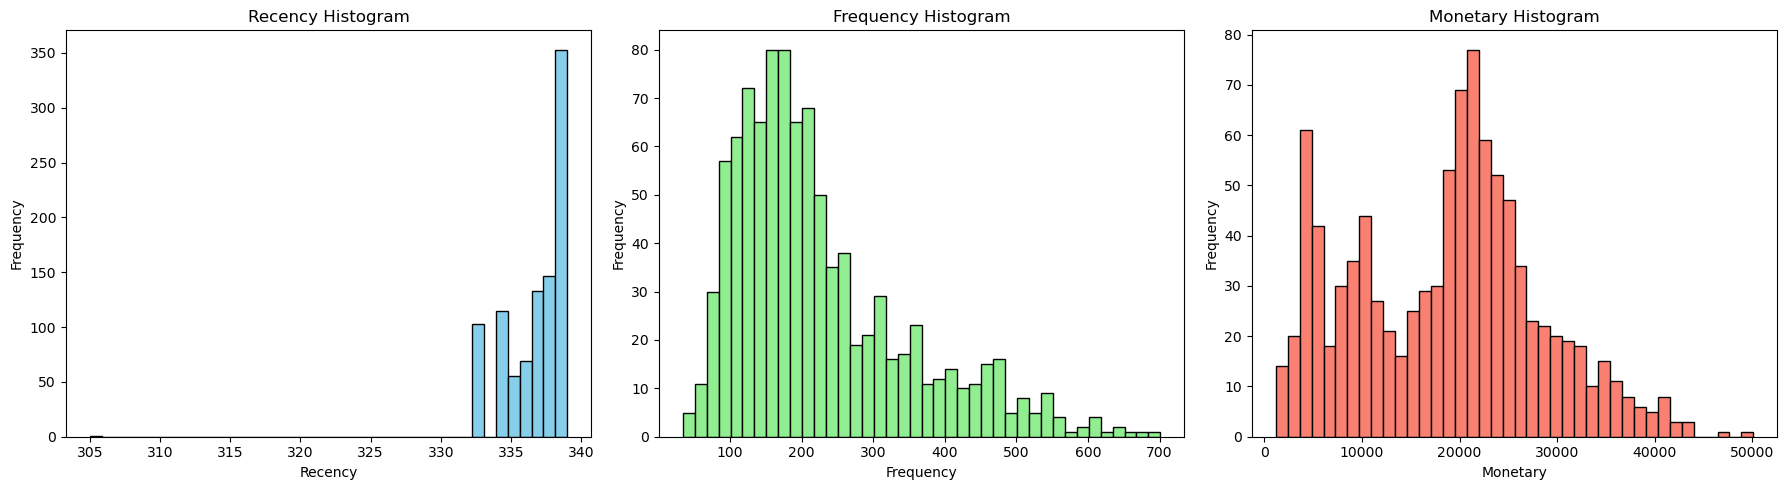

In [29]:
# Create histograms
fig, ax = plt.subplots(1, 3, figsize=(18, 5))  # Setup a figure with 3 subplots

# Recency Histogram
rfm_df['Recency'].plot(kind='hist', ax=ax[0], bins=40, color='skyblue', edgecolor='black')
ax[0].set_title('Recency Histogram')
ax[0].set_xlabel('Recency')
ax[0].set_ylabel('Frequency')

# Frequency Histogram
rfm_df['Frequency'].plot(kind='hist', ax=ax[1], bins=40, color='lightgreen', edgecolor='black')
ax[1].set_title('Frequency Histogram')
ax[1].set_xlabel('Frequency')

# Monetary Histogram
rfm_df['Monetary'].plot(kind='hist', ax=ax[2], bins=40, color='salmon', edgecolor='black')
ax[2].set_title('Monetary Histogram')
ax[2].set_xlabel('Monetary')

plt.tight_layout()  
plt.show()


In [40]:
# Counting the unique numbers in 'Recency' and their frequencies
recency_counts = rfm_df['Recency'].value_counts()

# Displaying the result
print(recency_counts)


339    353
338    147
337    133
334    115
333    103
336     69
335     55
305      1
Name: Recency, dtype: int64


One way to conduct RFM analysis is to assign each user a score for recency, frequency and monetary from 1-5. From the histograms it is apparent there is enough distribution for the Frequency and Monetary values to split equally. However, for the recency scores, it was more appropriate to create manual bins from the scale, as there is not much variation in the data. However, the recency scores had more variation than in dataset 1.

In [37]:
bins = [300, 330, 334, 336, 338, max(rfm_df['Recency'])]  
labels = [1, 2, 3, 4, 5]  
rfm_df['R_Score'] = pd.cut(rfm_df['Recency'], bins=bins, labels=labels).astype(int)
rfm_df['F_Score'] = pd.qcut(rfm_df['Frequency'], 5, labels=[1, 2, 3, 4, 5]).astype(int)
rfm_df['M_Score'] = pd.qcut(rfm_df['Monetary'], 5, labels=[1, 2, 3, 4, 5]).astype(int)

rfm_df['RFM_Score'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)
rfm_df

,Account No,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score
0,101531259.0,338,110,17627.58,4,1,3,413
1,104832000.0,336,150,25115.52,3,2,4,324
2,105375973.0,336,146,10067.28,3,2,2,322
3,106601471.0,339,180,7760.01,5,3,1,531
4,108481285.0,339,344,15062.28,5,5,2,552
...,...,...,...,...,...,...,...,...
971,995615876.0,338,172,17598.80,4,3,3,433
972,996042490.0,339,243,35268.01,5,4,5,545
973,998390769.0,334,140,21323.35,2,2,3,223
974,998405607.0,333,145,8816.16,2,2,1,221


### Investigating the types of spenders

The figure below shows how many users belong to each RFM scores. We can indentify that some combinations are more prominent than others.

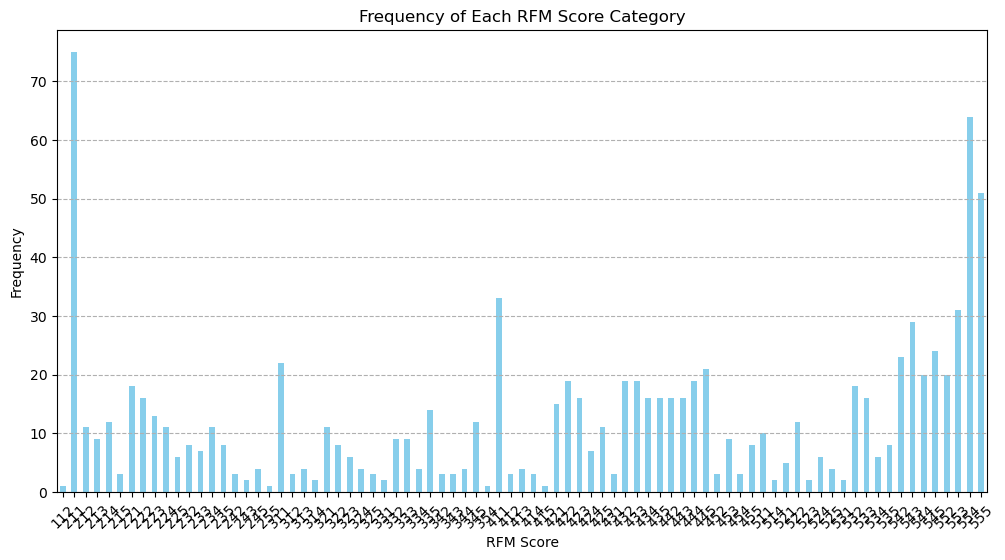

In [38]:
# Count the frequency of each RFM score category
rfm_score_counts = rfm_df['RFM_Score'].value_counts()

# Sort the RFM scores to ensure the histogram follows a logical order
rfm_score_counts = rfm_score_counts.sort_index()

# Plotting
plt.figure(figsize=(12, 6))
rfm_score_counts.plot(kind='bar', color='skyblue')
plt.title('Frequency of Each RFM Score Category')
plt.xlabel('RFM Score')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()


Using the table found from this website (https://connectif.ai/en/blog/what-are-rfm-scores-and-how-to-calculate-them/), we can assign client segments to each user, corresponding to their score. Below shows the information about each customer segment and potential strategies for each one:
- **Champion** (RFM: 555, 554, 544, 545, 454, 455, 445)
  - **Behavior:** Completed a recent purchase. They buy frequently and spend the most.
  - **Potential Strategies:** Reward them. Can be early adopters of new products. Act as brand ambassadors.

- **Loyal Customer** (RFM: 543, 444, 435, 355, 354, 345, 344, 335)
  - **Behavior:** They buy frequently and spend a lot of money on the site. Sensitive to offers.
  - **Potential Strategies:** Upsell. Offer high-value items to them. Ask for reviews. Build loyalty.

- **Potential Loyalist** (RFM: 553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441, 431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323)
  - **Behavior:** They recently spent a fair amount of money on the site more than once.
  - **Potential Strategies:** Invite them to join a loyalty program or get a membership. Recommend other products.

- **New Customer** (RFM: 512, 511, 422, 421, 412, 411, 311)
  - **Behavior:** Completed a recent purchase, but doesn’t order often.
  - **Potential Strategies:** Support them in their onboarding process. Get their satisfaction. Start to build loyalty.

- **Promising** (RFM: 525, 524, 523, 522, 521, 515, 514, 513, 425, 424, 413, 414, 415, 315, 314, 313)
  - **Behavior:** Completed a recent purchase, but didn’t spend a lot.
  - **Potential Strategies:** Create brand awareness. Offer discounts, gifts, and free trials.

- **Need Attention** (RFM: 535, 534, 443, 434, 343, 334, 325, 324)
  - **Behavior:** Above average in recency, frequency, and monetary value, but no recent purchases.
  - **Potential Strategies:** Launch limited-time offers and recommendations based on previous orders. Reactivate.

- **Cannot Lose Them** (RFM: 155, 154, 144, 214, 215, 115, 114, 113)
  - **Behavior:** Completed huge, frequent purchases long ago but haven’t come back since then.
  - **Potential Strategies:** Get them back with new product launches. Don’t let competitors take them. Talk to them.

- **About To Sleep** (RFM: 331, 321, 312, 221, 213)
  - **Behavior:** Below average in recency, frequency, and monetary value. At risk of losing them if you don’t reactivate.
  - **Potential Strategies:** Share useful information. Recommend popular products to them. Offer new discounts. Reconnect.

- **At Risk** (RFM: 255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 152, 145, 143, 142, 135, 134, 133, 125, 124)
  - **Behavior:** Completed big, frequent purchases long ago. You need to bring them back!
  - **Potential Strategies:** Send personalized emails to reconnect with special offers. Share useful resources.

- **Hibernating** (RFM: 332, 322, 231, 241, 251, 233, 232, 223, 222, 132, 123, 122, 212, 211)
  - **Behavior:** Their last purchase was long ago. The number of orders was small and the amounts spent low.
  - **Potential Strategies:** Offer relevant products and special discounts. Create brand value again.

- **Lost** (RFM: 111, 112, 121, 131, 141, 151)
  - **Behavior:** Lowest scores in recency, frequency, and monetary value.
  - **Potential Strategies:** Try to reactivate them with personalized campaigns. If it doesn’t work, ignore them.

In [39]:
# Defining the map of client segments based on RFM scores
client_segments_map = {
    "Champion": ["555", "554", "544", "545", "454", "455", "445"],
    "Loyal Customer": ["543", "444", "435", "355", "354", "345", "344", "335"],
    "Potential Loyalist": [
        "553", "551", "552", "541", "542", "533", "532", "531", "452", "451", "442", "441", "431", "453", "433", "432", 
        "423", "353", "352", "351", "342", "341", "333", "323"
    ],
    "New Customer": ["512", "511", "422", "421", "412", "411", "311"],
    "Promising": [
        "525", "524", "523", "522", "521", "515", "514", "513", "425", "424", "413", "414", "415", "315", "314", "313"
    ],
    "Need Attention": ["535", "534", "443", "434", "343", "334", "325", "324"],
    "Cannot Lose Them": [
        "155", "154", "144", "214", "215", "115", "114", "113"
    ],
    "About To Sleep": ["331", "321", "312", "221", "213"],
    "At Risk": [
        "255", "254", "245", "244", "253", "252", "243", "242", "235", "234", "225", "224", "153", "152", "145", "143", 
        "142", "135", "134", "133", "125", "124"
    ],
    "Hibernating": [
        "332", "322", "231", "241", "251", "233", "232", "223", "222", "132", "123", "122", "212", "211"
    ],
    "Lost": ["111", "112", "121", "131", "141", "151"]
}

# Inverting the map to make it easier to lookup by RFM score
rfm_score_to_segment_map = {score: segment for segment, scores in client_segments_map.items() for score in scores}

# Assuming 'rfm_df' is your DataFrame and it already has an 'RFM_Score' column
# Mapping each user's RFM score to the corresponding client segment
rfm_df['Client_Segment'] = rfm_df['RFM_Score'].map(rfm_score_to_segment_map)

# Let's display the first few rows to verify the 'Client_Segment' column
rfm_df.head()


,Account No,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Client_Segment
0,101531259.0,338,110,17627.58,4,1,3,413,Promising
1,104832000.0,336,150,25115.52,3,2,4,324,Need Attention
2,105375973.0,336,146,10067.28,3,2,2,322,Hibernating
3,106601471.0,339,180,7760.01,5,3,1,531,Potential Loyalist
4,108481285.0,339,344,15062.28,5,5,2,552,Potential Loyalist


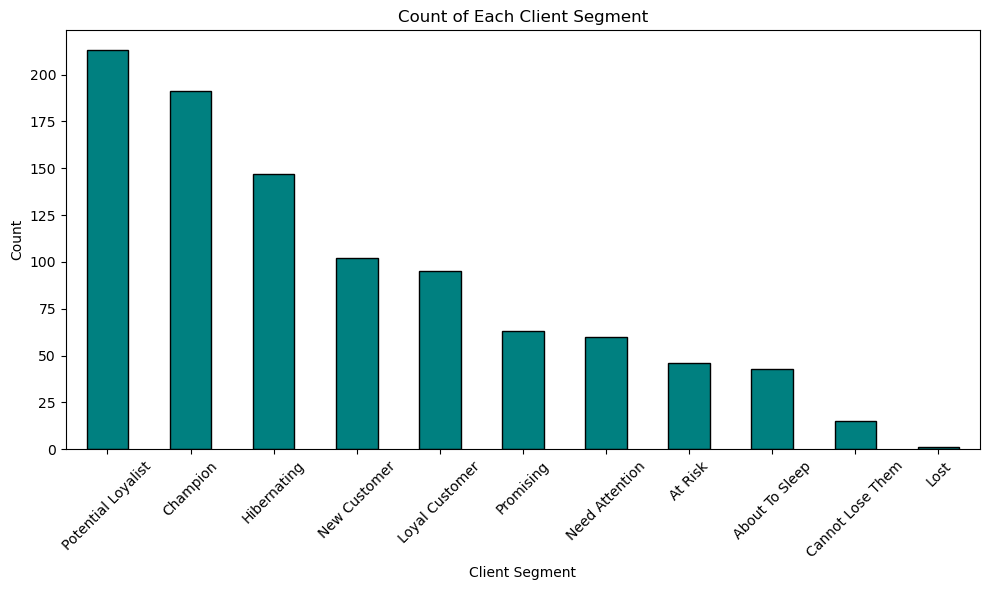

In [41]:
import matplotlib.pyplot as plt

# Assuming the DataFrame is named rfm_df and it has a 'Client_Segment' column as described
client_segment_counts = rfm_df['Client_Segment'].value_counts()

# Creating a bar chart
plt.figure(figsize=(10, 6))
client_segment_counts.plot(kind='bar', color='teal', edgecolor='black')
plt.title('Count of Each Client Segment')
plt.xlabel('Client Segment')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Clustering Customer Segments through k-means

/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_

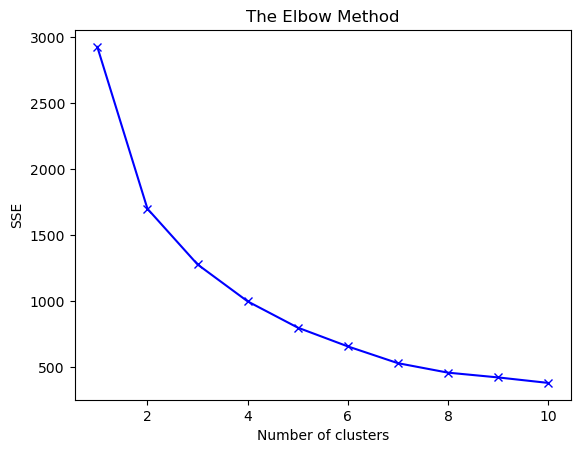

In [42]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_scaled)
    sse[k] = kmeans.inertia_  
    

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('The Elbow Method')
plt.show()

### Using 3 clusters

In [44]:
#Run the K-means algorithm
# Choose the optimal number of clusters 
kmeans = KMeans(n_clusters=3, random_state=1)
rfm_df['Customer_Segment_Kmeans_3'] = kmeans.fit_predict(rfm_scaled)

# Accessing the centroids
centroids = kmeans.cluster_centers_

# Displaying the centroids
print("Centroids of each cluster:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid}")
    
rfm_df.head()

Centroids of each cluster:
Cluster 0: [0.82374999 1.64667609 0.63016719]
Cluster 1: [-0.87825344 -0.78958155 -0.91395369]
Cluster 2: [ 0.31247161 -0.13663209  0.42981273]


/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Account No,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Client_Segment,Customer_Segment_Kmeans_3
0,101531259.0,338,110,17627.58,4,1,3,413,Promising,2
1,104832000.0,336,150,25115.52,3,2,4,324,Need Attention,2
2,105375973.0,336,146,10067.28,3,2,2,322,Hibernating,1
3,106601471.0,339,180,7760.01,5,3,1,531,Potential Loyalist,2
4,108481285.0,339,344,15062.28,5,5,2,552,Potential Loyalist,0


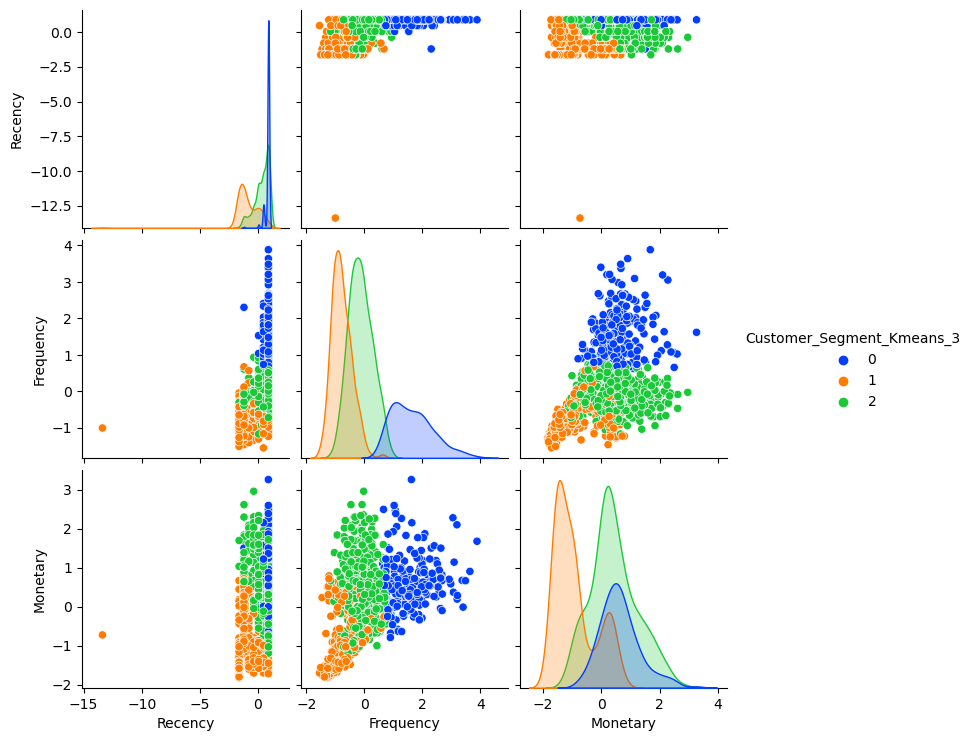

In [45]:
# Add the cluster assignments and the scaled RFM values back into the dataframe for plotting
rfm_df_plot = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency', 'Monetary'])
rfm_df_plot['Customer_Segment_Kmeans_3'] = kmeans.labels_ 

# Use seaborn's pairplot to create pairwise scatter plots
sns.pairplot(rfm_df_plot, hue='Customer_Segment_Kmeans_3', vars=['Recency','Frequency', 'Monetary'], palette='bright')
plt.show()

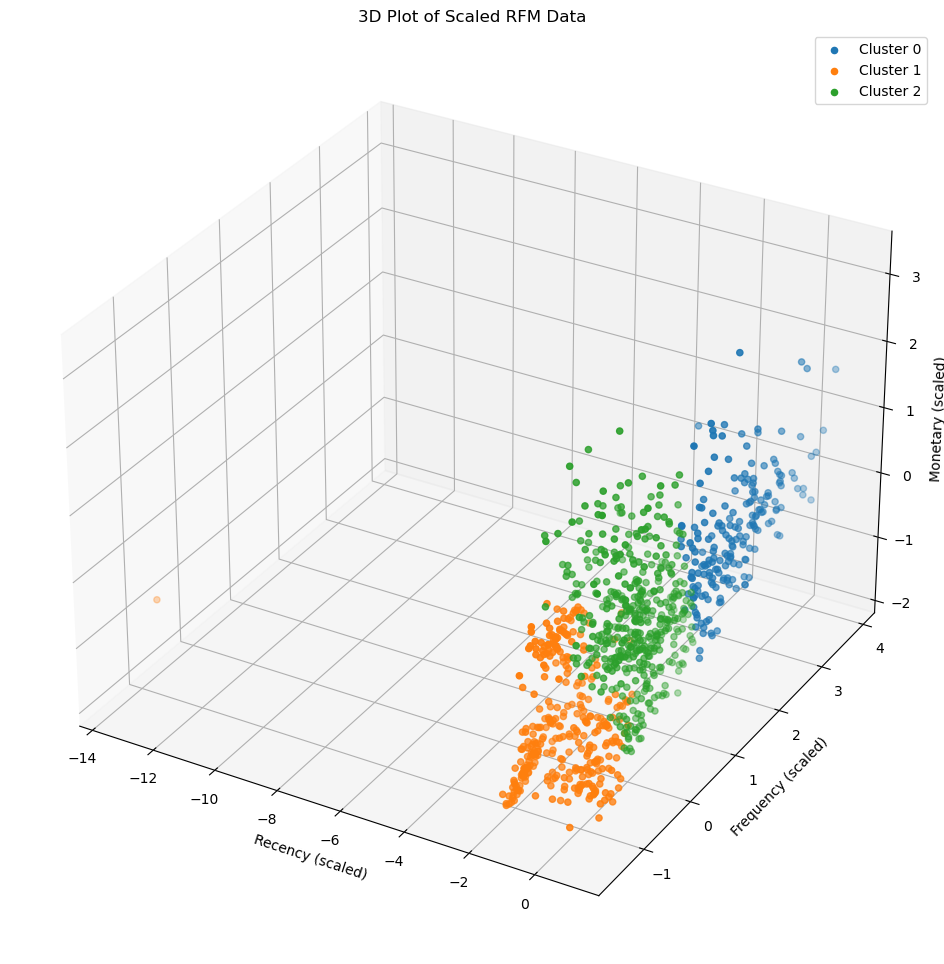

In [53]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color and label
for i in np.unique(kmeans.labels_):
    ax.scatter(rfm_scaled[kmeans.labels_ == i, 0], rfm_scaled[kmeans.labels_ == i, 1], rfm_scaled[kmeans.labels_ == i, 2], 
               label=f'Cluster {i}')

ax.set_xlabel('Recency (scaled)')
ax.set_ylabel('Frequency (scaled)')
ax.set_zlabel('Monetary (scaled)')
ax.set_title('3D Plot of Scaled RFM Data')
ax.legend()  
plt.show()

### Using 4 clusters

In [54]:
#Run the K-means algorithm
# Choose the optimal number of clusters 
kmeans = KMeans(n_clusters=4, random_state=1)
rfm_df['Customer_Segment_Kmeans_4'] = kmeans.fit_predict(rfm_scaled)

# Accessing the centroids
centroids = kmeans.cluster_centers_

# Displaying the centroids
print("Centroids of each cluster:")
for i, centroid in enumerate(centroids):
    print(f"Cluster {i}: {centroid}")
    
rfm_df.head()

Centroids of each cluster:
Cluster 0: [ 0.37449191 -0.52537657 -0.94924994]
Cluster 1: [0.82502547 1.62829444 0.58250337]
Cluster 2: [ 0.22556308 -0.12824657  0.73110706]
Cluster 3: [-1.38142561 -0.78407067 -0.73636066]


/Users/jessiebloom/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


,Account No,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Score,Client_Segment,Customer_Segment_Kmeans_3,Customer_Segment_Kmeans_4
0,101531259.0,338,110,17627.58,4,1,3,413,Promising,2,0
1,104832000.0,336,150,25115.52,3,2,4,324,Need Attention,2,2
2,105375973.0,336,146,10067.28,3,2,2,322,Hibernating,1,0
3,106601471.0,339,180,7760.01,5,3,1,531,Potential Loyalist,2,0
4,108481285.0,339,344,15062.28,5,5,2,552,Potential Loyalist,0,1


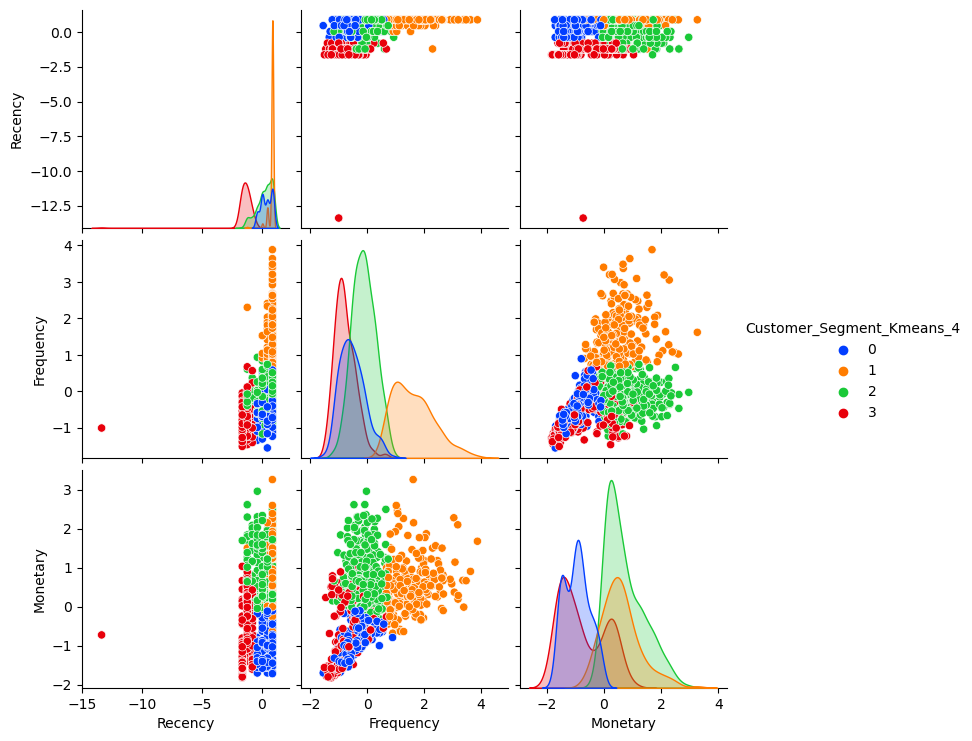

In [55]:
# Add the cluster assignments and the scaled RFM values back into the dataframe for plotting
rfm_df_plot = pd.DataFrame(rfm_scaled, columns=['Recency','Frequency', 'Monetary'])
rfm_df_plot['Customer_Segment_Kmeans_4'] = kmeans.labels_ 

# Use seaborn's pairplot to create pairwise scatter plots
sns.pairplot(rfm_df_plot, hue='Customer_Segment_Kmeans_4', vars=['Recency','Frequency', 'Monetary'], palette='bright')
plt.show()

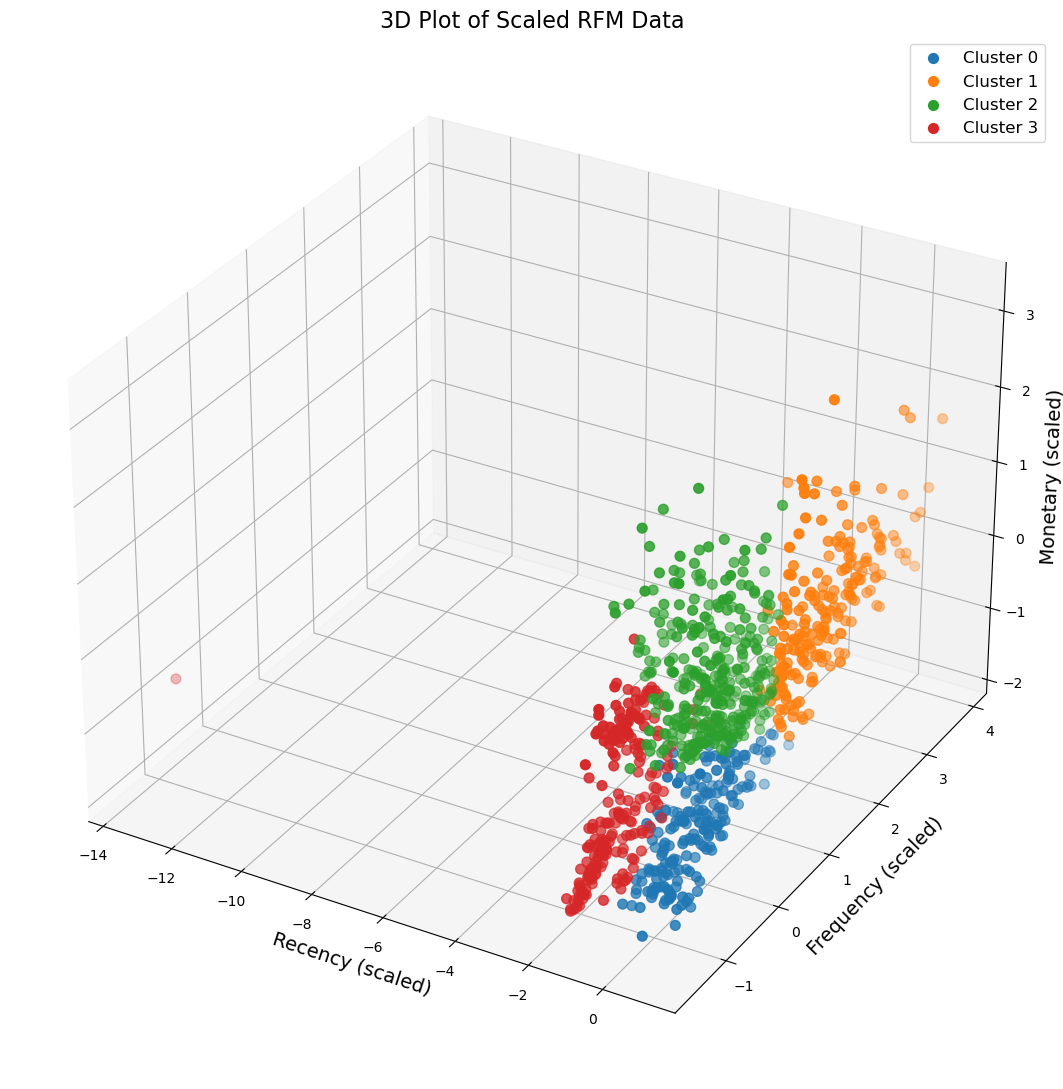

In [56]:
fig = plt.figure(figsize=(11, 11))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color and label
for i in np.unique(kmeans.labels_):
    ax.scatter(rfm_scaled[kmeans.labels_ == i, 0], rfm_scaled[kmeans.labels_ == i, 1], rfm_scaled[kmeans.labels_ == i, 2], 
               label=f'Cluster {i}', s=50)  # s is the size of the points

# Set the labels and title with a larger font size
ax.set_xlabel('Recency (scaled)', fontsize=14)
ax.set_ylabel('Frequency (scaled)', fontsize=14)
ax.set_zlabel('Monetary (scaled)', fontsize=14)
ax.set_title('3D Plot of Scaled RFM Data', fontsize=16)

# Increase the legend font size
ax.legend(fontsize=12)

# Improve the layout and display the plot
plt.tight_layout()
plt.show()

### Clustering through Gaussian Mixture Model- 3 clusters

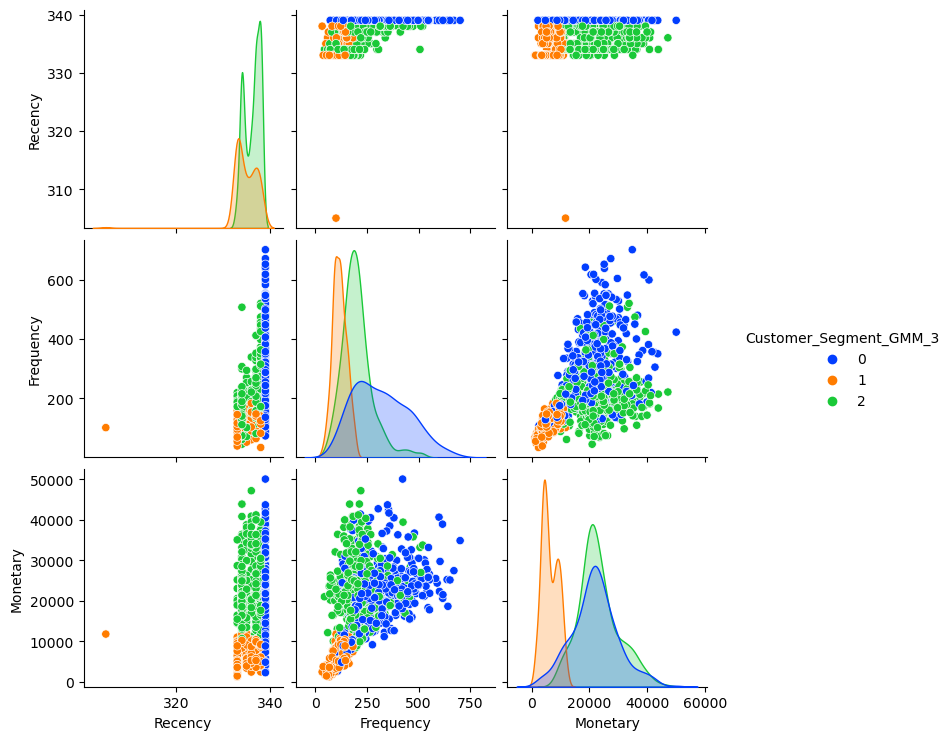

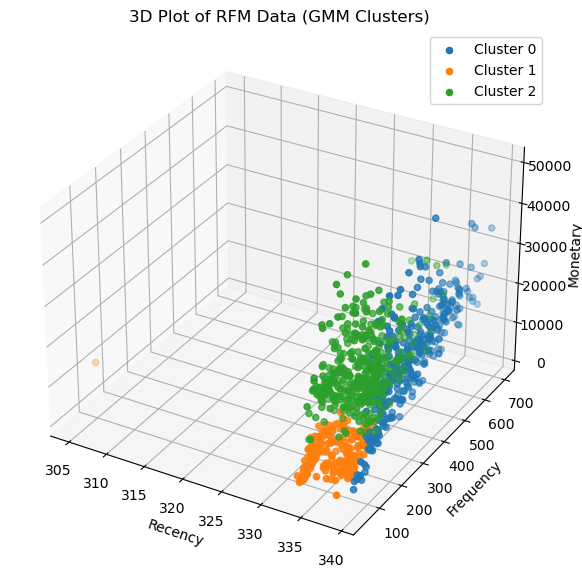

In [57]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=1) 
rfm_df['Customer_Segment_GMM_3'] = gmm.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Step 2: Draw a pairplot
sns.pairplot(rfm_df, hue='Customer_Segment_GMM_3', vars=['Recency', 'Frequency', 'Monetary'], palette='bright')
plt.show()

# Step 3: Create a 3D diagram
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(rfm_df['Customer_Segment_GMM_3']):
    ax.scatter(rfm_df.loc[rfm_df['Customer_Segment_GMM_3'] == i, 'Recency'],
               rfm_df.loc[rfm_df['Customer_Segment_GMM_3'] == i, 'Frequency'],
               rfm_df.loc[rfm_df['Customer_Segment_GMM_3'] == i, 'Monetary'],
               label=f'Cluster {i}')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Plot of RFM Data (GMM Clusters)')
ax.legend()
plt.show()

### GMM with 4 clusters

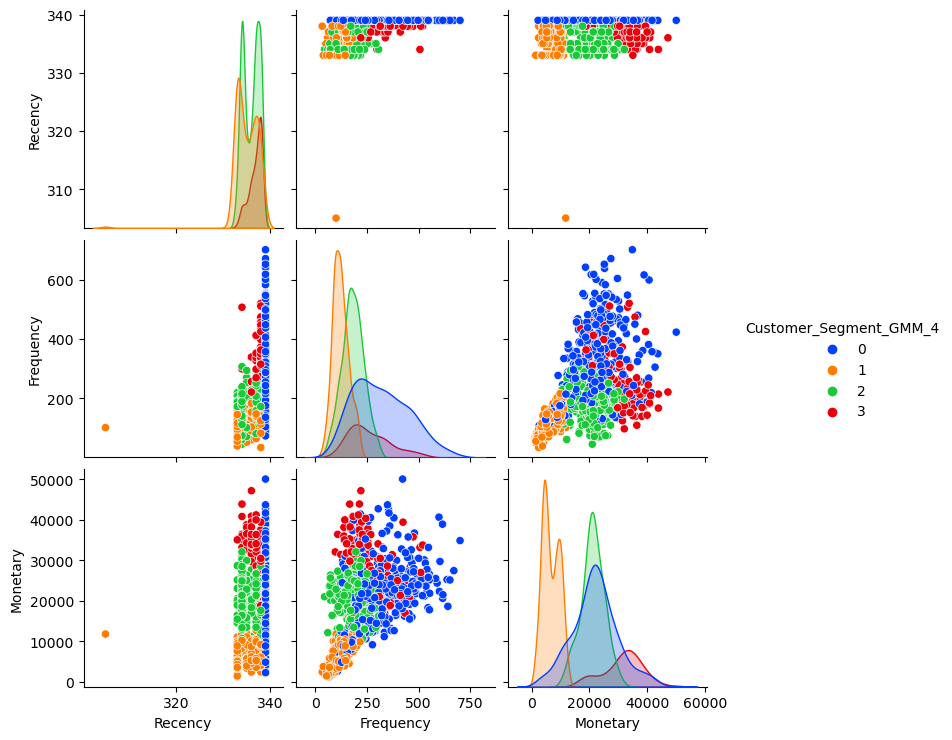

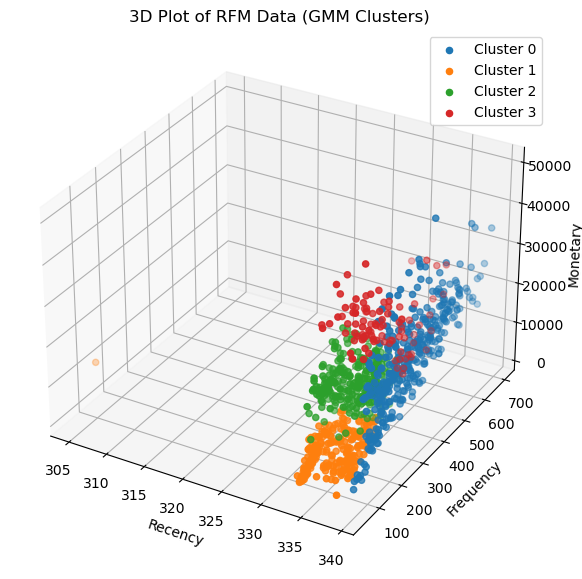

In [58]:
# Fit the Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=1) 
rfm_df['Customer_Segment_GMM_4'] = gmm.fit_predict(rfm_df[['Recency', 'Frequency', 'Monetary']])

# Step 2: Draw a pairplot
sns.pairplot(rfm_df, hue='Customer_Segment_GMM_4', vars=['Recency', 'Frequency', 'Monetary'], palette='bright')
plt.show()

# Step 3: Create a 3D diagram
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in np.unique(rfm_df['Customer_Segment_GMM_4']):
    ax.scatter(rfm_df.loc[rfm_df['Customer_Segment_GMM_4'] == i, 'Recency'],
               rfm_df.loc[rfm_df['Customer_Segment_GMM_4'] == i, 'Frequency'],
               rfm_df.loc[rfm_df['Customer_Segment_GMM_4'] == i, 'Monetary'],
               label=f'Cluster {i}')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D Plot of RFM Data (GMM Clusters)')
ax.legend()
plt.show()


The guassian mixture model does not work very well because its primary assumption is the dataset consists of multiple Gaussians, in other words, a mixture of the gaussian. The kind of distribution is often called multi-model distribution. Each peak represents the different gaussian distribution or the cluster in our dataset. You can see by the diagonals on the pairplot that